In [1]:
## call the main routines
using NBInclude
@nbinclude("core_fun.ipynb");

We fix the parameters for the case of France in an object of type Country. The calibrated values for $\alpha$, $m$ and $q$ (and $\lambda$) are obtained latter on.

In [2]:
lambda_function(q) = 1/quadgk(x-> UIpolicy_france(x) * q * exp(-q*x), 0, Inf)[1] 

france = let 
    
    reform = 1
    A = 25.  *12 # entitlement age to RMI
    Amin = 20. *12
    Amax = 36. *12
    
    r = 0.0048 # 5 % annual interest rate, time unit = month
    c0 = 1. # scale parameter of the cost function, normalized to 1 
    
    ### to be updated after the calibration
    alpha, m, q =  0.3, 0.3, 0.07
    lambdamin = lambda_function(q)
    lambdamax = lambda_function(q)
  
    uinit = [0.36,0.] ## start with 64% employment rate, 36% without UI
    
    b0max = 539 # RMI+housing benefits, from BD2011
    b0min = 206 # housing benefits without RMI, from BD2011
    wbar = 1.66 * b0max # average wage, 66% increase in relative gains from working for HS dropouts, from BD2011    
    b0max /= wbar
    b0min /= wbar
    wbar = 1
    bUI = 0.68   # 68% replacement rate from DARES
    
    Country(reform,A,Amin,Amax,r,c0,alpha,q,m,lambdamin,lambdamax,uinit,bUI,b0max,b0min,wbar)
end
;

# 1) Find $\alpha$ and $m$ for different values of $q$
We take as moments the employment rates from 24 to 26.

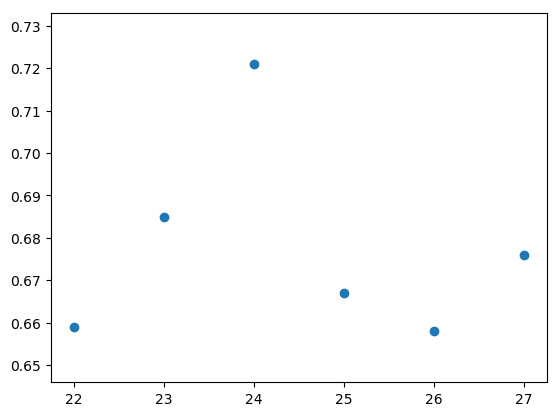

distance (generic function with 1 method)

In [3]:
function moments_france(unemp,simu::Simu,C::Country)
  #  Y22 = quadgk(x->1-sum(unemp(x)[:]) ,22*12,22*12+12)[1]/12
  #  Y23 = quadgk(x->1-sum(unemp(x)[:]) ,23*12,23*12+12)[1]/12
    Y24 = quadgk(x->1-sum(unemp(x)[:]) ,24*12,24*12+12)[1]/12
    Y25 = quadgk(x->1-sum(unemp(x)[:]) ,25*12,25*12+12)[1]/12
    Y26 = quadgk(x->1-sum(unemp(x)[:]) ,26*12,26*12+12)[1]/12
  #  Y27 = quadgk(x->1-sum(unemp(x)[:]) ,27*12,27*12+12)[1]/12
    return(    [ Y24, Y25, Y26])
end

moments_target = let
    Y22, Y23, Y24, Y25, Y26, Y27 = 0.659, 0.685, 0.721, 0.667, 0.658, 0.676
    scatter(22:27, [Y22, Y23, Y24, Y25, Y26, Y27])
    [Y24, Y25, Y26]
end

function distance(m1,m2)
    out = 0
    for i in 1:length(m1)
        out += (m1[i] - m2[i]) ^2  
    end
    return(out)
end

In [4]:
## generate a Country object with new values for alpha, m, q and lambda
function update_Country(alpha,m,q,C::Country)
    Country(C.reform,C.A,C.Amin,C.Amax,C.r,C.c0,
        alpha, q, m,lambda_function(q),lambda_function(q),
        C.uinit,C.bUI,C.b0max,C.b0min,C.wbar)
end

## compute the objective to minimise
function objective_fr(alpha,m,q,C::Country)
    newC = update_Country(alpha,m,q,C)
    
    ## simulate
    simu = find_simu(newC,reltol=1e-6)
    unemp = find_unemp(simu, newC, unitSS = false) 
    moments_emp = moments_france(unemp,simu,newC)
    
    IJulia.clear_output(true)
    println(alpha," ",m," ",q)
    println(moments_emp)
    
    distance(moments_emp,moments_target)
end

function find_france(q,C::Country)
    opt = Opt(:LN_BOBYQA, 2)
    lower_bounds!(opt, [0.1 , 0.])
    upper_bounds!(opt, [10. , 1.])
    xtol_rel!(opt,1e-8)
    stopval!(opt,1e-15)
    min_objective!(opt, (v,g)-> objective_fr(v[1],v[2],q,C))
    
    init =  [0.6, 0.7] 
    
    (minf,minx,ret) = optimize(opt, init) 
    println("Param found with convergence ", ret, ", the value of the objective is ",minf)
    println(minx[1], "  ",minx[2])
    return(minx)
end

q_vec = [0.005, 0.01, 0.025, 0.05, 0.1]
am_vec = zeros(2,5)
for (i,q) in enumerate(q_vec)
    am_vec[:,i] =  find_france(q,france)
end
am_vec

0.3324607291912278 0.42966287760655103 0.1
[0.721074, 0.666084, 0.658814]
Param found with convergence SUCCESS, the value of the objective is 1.506397734181458e-6
0.3324607277586237  0.42966287529617386


2×5 Array{Float64,2}:
 0.106317   0.262027   0.355445  0.329717  0.332461
 0.0216856  0.0408066  0.106458  0.21395   0.429663

# 2) Statistics for each value of $q$

In [5]:
lam_vec = zeros(length(q_vec))
jfr0bef_vec = zeros(length(q_vec))
jfr0aft_vec = zeros(length(q_vec))
mom_vec = zeros(length(moments_target),length(q_vec))

for (i,q) in enumerate(q_vec)
    newC = update_Country(am_vec[1,i], am_vec[2,i], q, france)
    lam_vec[i] = newC.lambdamin
    simu_fr = find_simu(newC,reltol=1e-5)
    jfr0bef_vec[i] = JFrate(simu_fr.Xbar1(22*12),newC)
    jfr0aft_vec[i] = JFrate(simu_fr.Xbar1(newC.A),newC)
    
    unemp_fr = find_unemp(simu_fr, newC, unitSS = false) 
    mom_vec[:,i] = moments_france(unemp_fr,simu_fr,newC)
end

mid_vec = vcat(mom_vec .*100 ,lam_vec',jfr0bef_vec',jfr0aft_vec')

6×5 Array{Float64,2}:
 71.3952     71.5015     71.7904     72.0293     72.1074   
 68.1491     68.0095     67.5799     67.0553     66.6078   
 65.0578     65.1036     65.2538     65.5317     65.8814   
  0.0350824   0.0369089   0.0428786   0.0546188   0.0860489
  0.0224442   0.0428922   0.126155    0.285951    0.586755 
  0.0024881   0.0138574   0.0501817   0.11503     0.242262 

# 3) RDD for each value of $q$

In [6]:
coef_vec = zeros(length(q_vec))
late_vec = zeros(length(q_vec))

age_grid = 20:35
for (i,q) in enumerate(q_vec)
    newC = update_Country(am_vec[1,i], am_vec[2,i], q, france)
    simu_fr = find_simu(newC,reltol=1e-5)
    unemp_fr = find_unemp(simu_fr, newC, unitSS = false) 

    ## employment rate as dependent variable
    Y = [quadgk(x->1-sum(unemp_fr(x)[:]) ,m,m+12)[1]/12 for m in 12*age_grid] 

    # linear spline
    TREAT = [a>=france.A for a in age_grid*12]
    consta = ones(size(age_grid))
    age1 = collect(age_grid*12)
    age2 = age1 .^2
    age3 = age1 .^3
    age1_spl = (age1 .- france.A) .* TREAT 
    X = hcat(TREAT, consta, age1, age1_spl)
    beta = inv(X' * X) * (X' * Y)
    coef_vec[i] = beta[1]

    unemp_fr_counter0 = find_unemp_counter0(simu_fr, newC, unitSS = false) 
    unemp_fr_counter1 = find_unemp_counter1(simu_fr, newC, unitSS = false) 

    emp_after = 1-sum(unemp_fr_counter1(newC.A)[:])
    emp_before = 1-sum(unemp_fr_counter0(newC.A)[:])
    late_vec[i] = emp_after-emp_before
end

late_vec

5-element Array{Float64,1}:
 -0.3271585091584752 
 -0.19571575812665676
 -0.11149842141566535
 -0.08470661499285392
 -0.07111227611661386

# The final table is

In [7]:
vcat(q_vec',am_vec,mid_vec,-0.049 .* ones(length(q_vec))',coef_vec',late_vec')

12×5 Array{Float64,2}:
  0.005       0.01        0.025       0.05        0.1      
  0.106317    0.262027    0.355445    0.329717    0.332461 
  0.0216856   0.0408066   0.106458    0.21395     0.429663 
 71.3952     71.5015     71.7904     72.0293     72.1074   
 68.1491     68.0095     67.5799     67.0553     66.6078   
 65.0578     65.1036     65.2538     65.5317     65.8814   
  0.0350824   0.0369089   0.0428786   0.0546188   0.0860489
  0.0224442   0.0428922   0.126155    0.285951    0.586755 
  0.0024881   0.0138574   0.0501817   0.11503     0.242262 
 -0.049      -0.049      -0.049      -0.049      -0.049    
 -0.0759403  -0.0886197  -0.0727194  -0.0558992  -0.0541496
 -0.327159   -0.195716   -0.111498   -0.0847066  -0.0711123